# Asset data exploration

In [1]:
# Basic init cell
%load_ext autoreload
%autoreload 2
%config IPCompleter.greedy=True

import os
import sys
sys.path.append("../") # go to parent dir
from src.constants import DATA_PATH, PROJECT_PATH

In [2]:
# data processing
import numpy as np
import pandas as pd

# plotting
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import seaborn as sns
import folium
import folium.plugins

## Import asset dataset

In [3]:
asset_file = os.path.join(
    DATA_PATH, "Shipston Assets 8.10 Cambridge snapshot (first 200 assets).xlsx"
)

# Import data
nfm_assets = pd.read_excel(asset_file, header=1)
# Rename longitude and latitude coords
nfm_assets = nfm_assets.rename(columns={"x": "longitude", "y": "latitude"})

# Get the log10 price (due to varying price orders of magnitude)
nfm_assets["log10_price"] = np.log10(nfm_assets["Installed Cost (£)"] + 0.01)

# Finding all asset types
asset_types = nfm_assets["Asset Type"].unique()
print("Found asset types:", asset_types)

Found asset types: ['leaky_barriers' 'offline_storage_areas' 'runoff_pathway_management'
 'cross_slope_woodland_creation' 'riparian_woodland_creation'
 'river_restoration']


## Asset exploration

### Generate pandas profiling report

In [4]:
#from pandas_profiling import ProfileReport

## Perform the profiling
#profile = ProfileReport(nfm_assets, 
#                        title="Asset data profiling report")

## Save as html
#report_file = os.path.join(PROJECT_PATH, "report", "profiling_detailed.html")
#profile.to_file(report_file)

### What type of information do we have on each asset?

In [5]:
print(
    "Columns:\n", "\n".join([f"{i}\t{col}" for i, col in enumerate(nfm_assets.columns)])
)

Columns:
 0	ObjectID
1	GlobalID
2	Select project
3	FR1_ProjectName
4	Asset ID:
5	Asset Type
6	Asset Description
7	Date Installed
8	Installed Cost (£)
9	Watercourse Type
10	Stream Width (m)
11	Land Drainage Consent Difficulty
12	Ecological Consent Difficulty
13	Average member length in Leaky Barrier (m)
14	Wood Diameter (cm)
15	Height of Leaky Barrier above bed (cm)
16	Height of Leaky Barrier above bank (cm)
17	Wood Species Used
18	Other Wood Species
19	Bund height (m)
20	Bund width (m)
21	Bund length (m)
22	Bund Material
23	Gully Block Length (m)
24	Gully Block Width (m)
25	Gully Block Material
26	Soil Equipment or Technique Used
27	Flood Efficacy
28	FR3 Area Units
29	FR3_AreaRough
30	Storage Created (m3)
31	FR3_AreaIncreasedLoss
32	Changed Flood Pathway?
33	Reduced Erosion?
34	Asset Condition
35	Date Assessed
36	Comments
37	CreationDate
38	Creator
39	EditDate
40	Editor
41	longitude
42	latitude
43	log10_price


Quite a few of these seem relevant. Most of all the geographical locations, installation dates, and storage areas.
Let's go ahead and analyse some key features and relations of this data.

### What are the assets we have and how many are there?

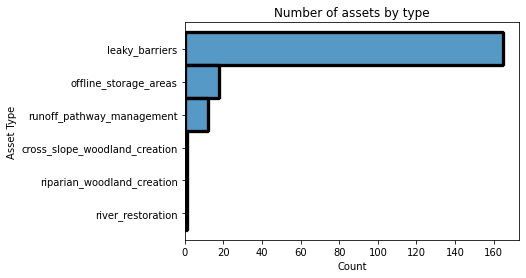

In [6]:
# Plot number of assets per type
sns.histplot(data=nfm_assets, y="Asset Type")
plt.title("Number of assets by type")
plt.show()

So the large majority of assets are acutally __leaky barriers__. 

### How do the different assets compare wrt price? Which are the most expensive?

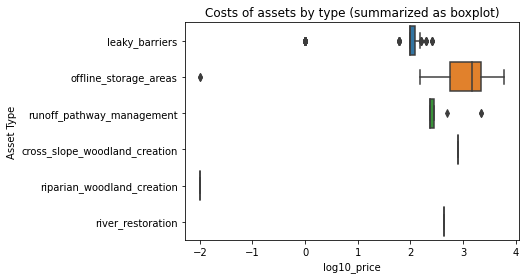

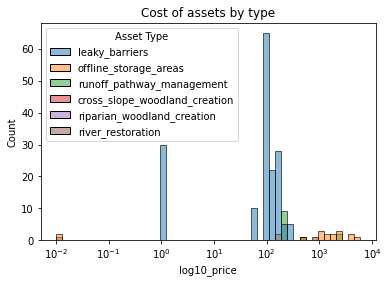

In [7]:
# Plot prices as boxenplot
plt.title("Costs of assets by type (summarized as boxplot)")
sns.boxplot(data=nfm_assets, y="Asset Type", x="log10_price")
plt.show()

# Plot price distribution per asset type
sns.histplot(data=nfm_assets, bins=50, x="log10_price", hue="Asset Type", alpha=0.5)
exponents = [-2, -1, 0, 1, 2, 3, 4]
plt.xticks(exponents, ["$10^{%d}$" % d for d in exponents])
plt.title("Cost of assets by type")
plt.show()

We observe
- The most common assets (__leaky barriers__) are __relatively cheap__ and typically __cost ~100 pound__.
- The more __expensive methods__ are __offline storage areas__ with typcial __prices in the ~1000 pound__ regime and __runoff pathway management__ for typically a __few hundred pound__.

### How the created storage size affect the price (esp. for the storage areas, which are the most expensive)? 

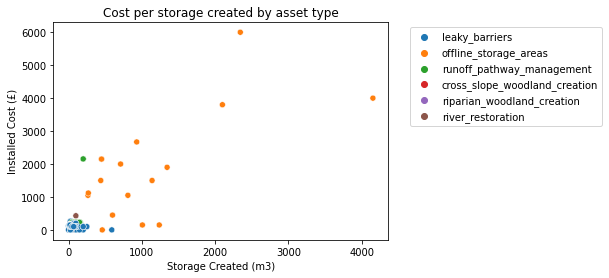

In [8]:
# Plot storage size as function of cost
sns.scatterplot(
    data=nfm_assets, y="Installed Cost (£)", x="Storage Created (m3)", hue="Asset Type"
)
plt.title("Cost per storage created by asset type")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.show()

Here we see that essentially the __storage volume__ created __correlates with the cost__ of the asset.
The relationship is pretty noisy (presumably due to other important factors such as the landowner, etc.) but 
from eyeballing it I would say __roughly__ the behavior seems to be __linear__. 

### Where are the storage areas located?

In [9]:
shipston_map = folium.Map(
    location=[52.120, -1.495],
    tiles="https://api.mapbox.com/styles/v1/croydonbrixton/ckg8jcp6c08vb19o089gcrp0b/tiles/256/{z}/{x}/{y}@2x?access_token=pk.eyJ1IjoiY3JveWRvbmJyaXh0b24iLCJhIjoiY2tmYTJzZDJiMHJ4YjJ5cXNzMjQzYXd5MSJ9.zUToqkuiUUEdWavpHmXpzQ",
    attr="Mapbox Control Room"
)

asset_color = {}
for asset_type, color in zip(asset_types, sns.color_palette().as_hex()):
    asset_color[asset_type] = color

for i, asset in nfm_assets.iterrows():
    folium.Marker(
        location=(asset.latitude, asset.longitude),
        icon=folium.Icon(color="blue", icon_color=asset_color[asset["Asset Type"]]),
        popup=f"ID:{i}: {asset['Asset Type']}",
        tooltip=f"ID:{i}: {asset['Asset Type']}",
    ).add_to(shipston_map)

shipston_map

In [10]:
shipston_map_agg = folium.Map(
    location=[52.120, -1.495],
    tiles="https://api.mapbox.com/styles/v1/croydonbrixton/ckg8jcp6c08vb19o089gcrp0b/tiles/256/{z}/{x}/{y}@2x?access_token=pk.eyJ1IjoiY3JveWRvbmJyaXh0b24iLCJhIjoiY2tmYTJzZDJiMHJ4YjJ5cXNzMjQzYXd5MSJ9.zUToqkuiUUEdWavpHmXpzQ",
    attr="Mapbox Control Room",
)

marker_cluster = folium.plugins.MarkerCluster().add_to(shipston_map_agg)

for i, asset in nfm_assets.iterrows():
    folium.Marker(
        location=(asset.latitude, asset.longitude),
        icon=folium.Icon(color="blue", icon_color=asset_color[asset["Asset Type"]]),
        popup=f"ID:{i}: {asset['Asset Type']}",
        tooltip=f"ID:{i}: {asset['Asset Type']}",
    ).add_to(marker_cluster)

shipston_map_agg

### When were the storage areas introduced? 

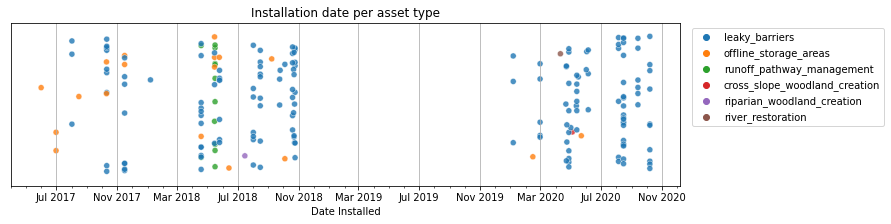

In [11]:
# Create figure and plot space
fig, ax = plt.subplots(figsize=(12, 3))

# Add x-axis and y-axis
dateplot = sns.scatterplot(
    x="Date Installed",
    y=np.random.uniform(0, 1, len(nfm_assets)),  # pull data apart via jitter
    hue="Asset Type",
    alpha=0.8,
    data=nfm_assets,
)

# Set title and labels for axes
ax.set(title="Installation date per asset type")

# Define the date format
date_form = DateFormatter("%b %Y")
ax.xaxis.set_major_formatter(date_form)

# Ensure a major tick every 4 months
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=4))
# Ensure minor tick for every month
ax.xaxis.set_minor_locator(mdates.MonthLocator(interval=1))

# Deactivate y ticks and create slight space below and above
plt.yticks([], [])
plt.ylim(-0.1, 1.1)

# Get grid for orientation
ax.grid()

# Set legend outside
dateplot.legend(bbox_to_anchor=(1.01, 1), loc="upper left")

plt.show()

There are quite a few interesting observations:
- all interventions where built __between 2017 and 2020__, tendentially from March to November.
- in 2020, the large majority of interventions are __leaky barriers__.
- in 2019 they __did not build anything__. Why? (Lack of funding? Entries not in dataset? Other reasons?)
- original interventions in 2017 and 2018 included __storage areas__ and __runoff pathways__ but these have rarely been built in 2020. Instead, in 2020 they mainly built leaky barriers. __Why?__ (Are leaky barriers seen to be more effective? Did they just not have the money to build storage areas? Where leaky barriers easier to build for some reason, e.g. landowners? ...?) 